In [15]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import tqdm
import scipy.ndimage as sim

import mltools.utils.cuda_tools as cuda_tools
from mltools.networks import networks

device=cuda_tools.get_freer_device()

import sys
sys.path.append('../')

import utils
import models
import importlib
importlib.reload(utils)

plt.rcParams.update({'font.size': 18})

memory_available [78449]
best GPU: 0


In [4]:
plot_datass={}
c=0
#for fol in glob.glob("../data/images_1/2x2x2_final/sc2ss2sb2/*/seed=*"):
for fol in glob.glob("../data/images_1/2x2x2_final/sc3ss1sb3/*/seed=*"):
    log_file=os.path.join(fol,"logs.pth")
    assert os.path.exists(log_file)
    parentfolname=os.path.basename(os.path.dirname(fol))
    sep_col=parentfolname.split("sep_col=")[1].split("_")[0]
    sep_size=parentfolname.split("sep_size=")[1].split("_")[0]
    sep_bg_col=parentfolname.split("sep_bg_col=")[1].split("_")[0]
    if sep_bg_col not in ["0.1","0.2","0.3"]:
        continue
    plot_data_file=os.path.join(fol,"plot_data.pth")
    plot_data=torch.load(plot_data_file)
    plot_data["sep_col"]=sep_col
    plot_data["sep_size"]=sep_size
    plot_data["sep_bg_col"]=sep_bg_col
    plot_datass.setdefault((sep_col,sep_size,sep_bg_col),[]).append(plot_data)
    c+=1
len(plot_datass),c

(9, 45)

In [6]:
i_image_show=16
config=utils.load_config('../data/images_1/2x2x2_final/sc3ss1sb3/sep_col=0.6_sep_size=0.35_sep_bg_col=0.3/seed=0/seed=0.yaml')
x_tr,y_tr,l_tr,x_te,y_te,l_te=utils.generate_data(config,seed=42,forgen=True)

In [12]:
i_step_min=0
plot_datas=plot_datass[list(plot_datass.keys())[0]]
save_steps=plot_datas[0]["save_steps"]
save_steps[i_step_min]

50

In [13]:
import matplotlib
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap="gnuplot"
norm = mcolors.Normalize(vmin=0.1, vmax=0.8)
def sep_col_to_color(sep_col,cmap="gnuplot"):
    return matplotlib.colormaps[cmap](norm(float(sep_col)))

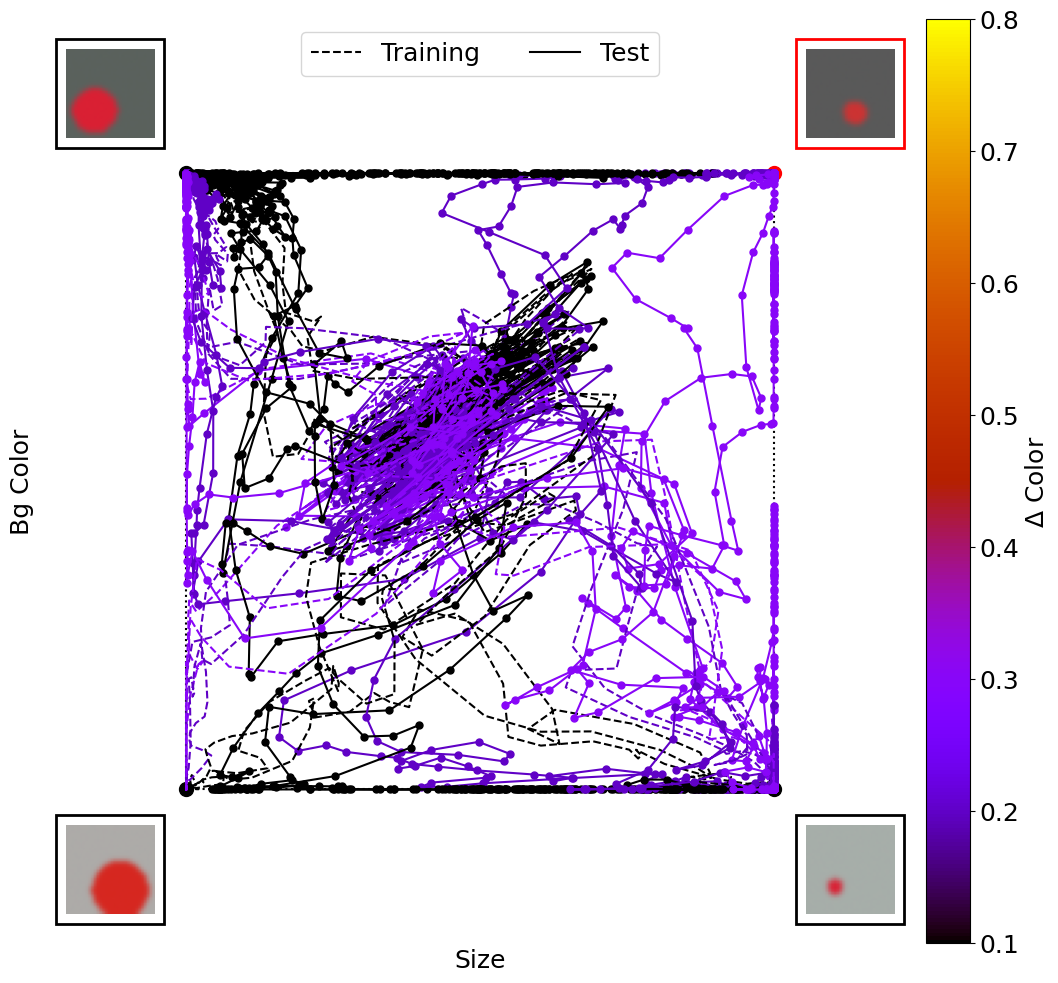

In [50]:
plt.figure(figsize=(12,12))
plt.plot([0,1,1,0,0,0],[0,0,1,1,0,0],c="k",ls=":")
plt.scatter([0,0,1],[0,1,0],c="k",s=100)
plt.scatter([1],[1],c="r",s=100)
trajs_trss=[]
trajs_tess=[]
sep_colss=[]
sep_sizess=[]
sep_bg_colss=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    sep_bg_col=key[2]
    sep_colss.append(float(sep_col))
    sep_sizess.append(float(sep_size))
    sep_bg_colss.append(float(sep_bg_col))
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)

    trajs_trs=[]
    for l in [0,1,2,4]:
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==l].mean((0,3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    trajs_tes=[]
    for l in [3,5,6,7]:
        trajs_tes.append(classprobs_pred_tes[:,:,:,l_te==l].mean((0,3)))
    trajs_tes=np.stack(trajs_tes,axis=0)

    trajs_trs=sim.gaussian_filter1d(trajs_trs,1.0,axis=1,truncate=6.0)
    trajs_tes=sim.gaussian_filter1d(trajs_tes,1.0,axis=1,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_tes)
    color=sep_col_to_color(sep_bg_col,cmap=cmap)
    #i_star=20
    #plt.plot(trajs_te[i_star,0],trajs_te[i_star,1],marker="*",c="r",markersize=20)
    for i in range(3):
        plt.plot(trajs_trs[i,i_step_min:,2],trajs_trs[i,i_step_min:,1],ls="--",c=color)
    for i in range(3):
        plt.plot(trajs_tes[i,i_step_min:,2],trajs_tes[i,i_step_min:,1],marker="o",c=color,markersize=5)
plt.xlim(-0.25,1.25)
plt.ylim(-0.25,1.25)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.ylabel("Bg Color")
plt.xlabel("Size")
plt.plot([],[],c="k",ls="--",label="Training")
plt.plot([],[],c="k",label="Test")
plt.legend(loc="upper center",ncol=2)

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
for l in [0,1,2,3]:
    i=np.random.randint(32)
    image=x_tr[l_tr==l][i].transpose(2,1,0) if l in [0,1,2] else x_te[l_te==l][i].transpose(2,1,0)
    imagebox = OffsetImage(image, zoom = 2.0)
    s=0.13
    coord={0:[0.-s,0.-s],1:[0.-s,1.+s],2:[1.+s,0.-s],3:[1.+s,1.+s]}[l]
    ab = AnnotationBbox(imagebox, coord, frameon = True ,bboxprops=dict(edgecolor="k" if l in [0,1,2] else "r",lw=2))
    plt.gca().add_artist(ab)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label(r"$\Delta$ Color")

In [51]:
sep_colss=np.array(sep_colss)
sep_sizess=np.array(sep_sizess)
sep_bg_colss=np.array(sep_bg_colss)

In [52]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
thres=0.1

In [53]:
trajs_trss=np.stack(trajs_trss,axis=0)
gt_trss=np.array([[0,0,0.],[0,0,1],[0,1,0],[1,0,0]])
accs_trss=sigmoid(1/(np.abs(gt_trss[None,:,None]-trajs_trss)/thres+1e-9))
labels_trss=["000","001","010","100"]

trajs_tess=np.stack(trajs_tess,axis=0)
gt_tess=np.array([[0,1,1],[1,0,1],[1,1,0],[1,1,1]])
accs_tess=sigmoid(1/(np.abs(gt_tess[None,:,None]-trajs_tess)/thres+1e-9))
labels_tess=["011","101","110","111"]

trajs_trss.shape,accs_trss.shape,trajs_tess.shape,accs_tess.shape

((9, 4, 120, 3), (9, 4, 120, 3), (9, 4, 120, 3), (9, 4, 120, 3))

In [97]:
i_data=2
sep_colss[i_data],sep_sizess[i_data],sep_bg_colss[i_data]

(0.6, 0.35, 0.1)

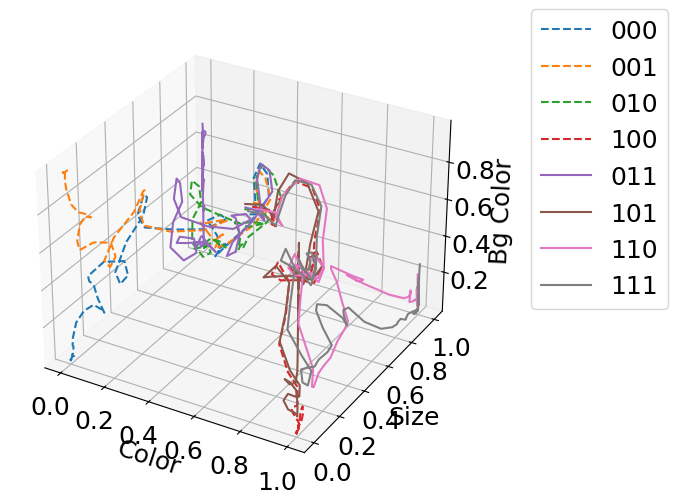

In [98]:
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111, projection='3d')
for i in range(4):
    traj=trajs_trss[i_data,i,:,:]
    plt.plot(traj[:,0],traj[:,1],traj[:,2],ls="--",label=labels_trss[i])
for i in range(4):
    traj=trajs_tess[i_data,i,:,:]
    plt.plot(traj[:,0],traj[:,1],traj[:,2],label=labels_tess[i])
ax.set_xlabel("Color")
ax.set_ylabel("Size")
ax.set_zlabel("Bg Color")
plt.legend(bbox_to_anchor=(1.1, 1.05))

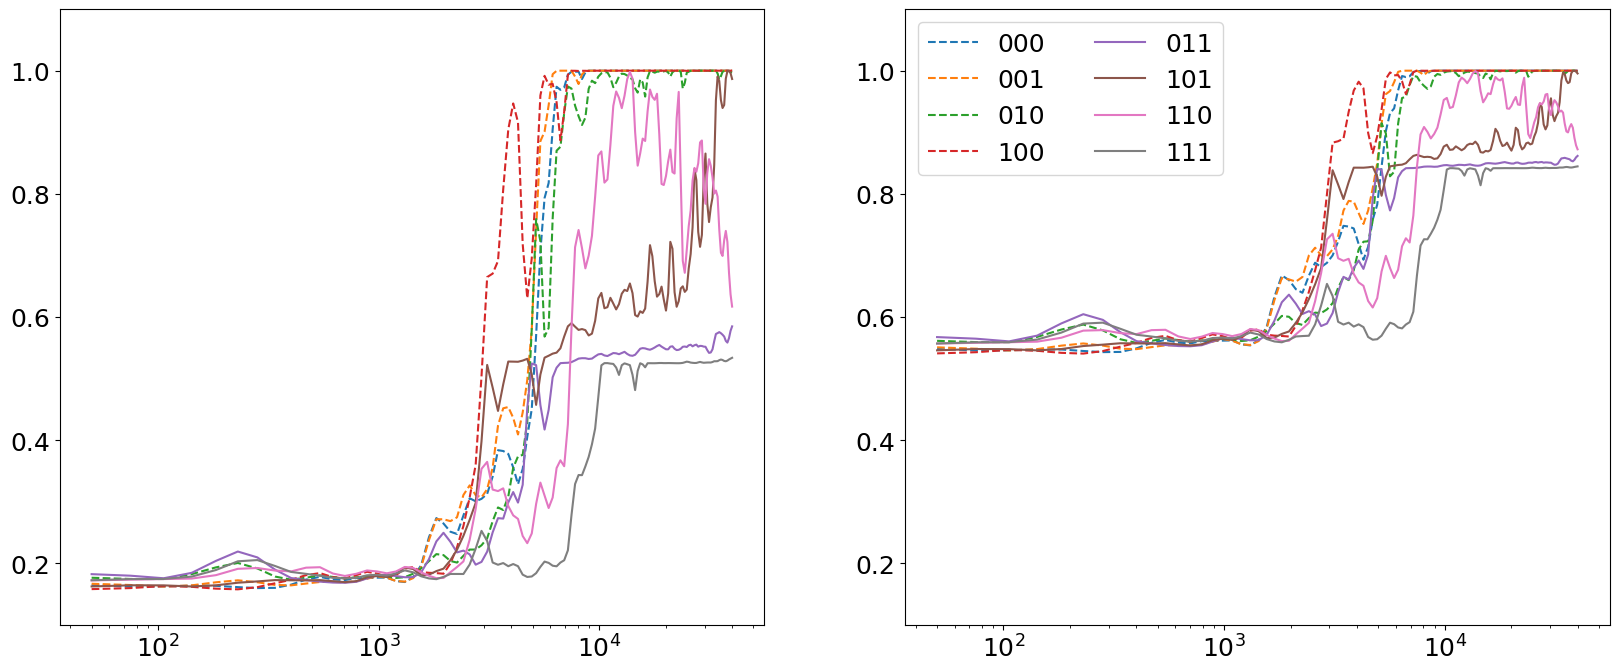

In [99]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
for i in range(4):
    _=plt.plot(save_steps,accs_trss[i_data,i].prod(-1),ls="--")
for i in range(4):
    _=plt.plot(save_steps,accs_tess[i_data,i].prod(-1),ls="-")
plt.xscale("log")
plt.ylim(0.1,1.1)

plt.subplot(1,2,2)
for i in range(4):
    _=plt.plot(save_steps,accs_trss[i_data,i].mean(-1),ls="--",label=labels_trss[i])
for i in range(4):
    _=plt.plot(save_steps,accs_tess[i_data,i].mean(-1),ls="-",label=labels_tess[i])
plt.xscale("log")
plt.ylim(0.1,1.1)
plt.legend(ncols=2)

In [112]:
labels=["000","001","010","011","100","101","110","111"]

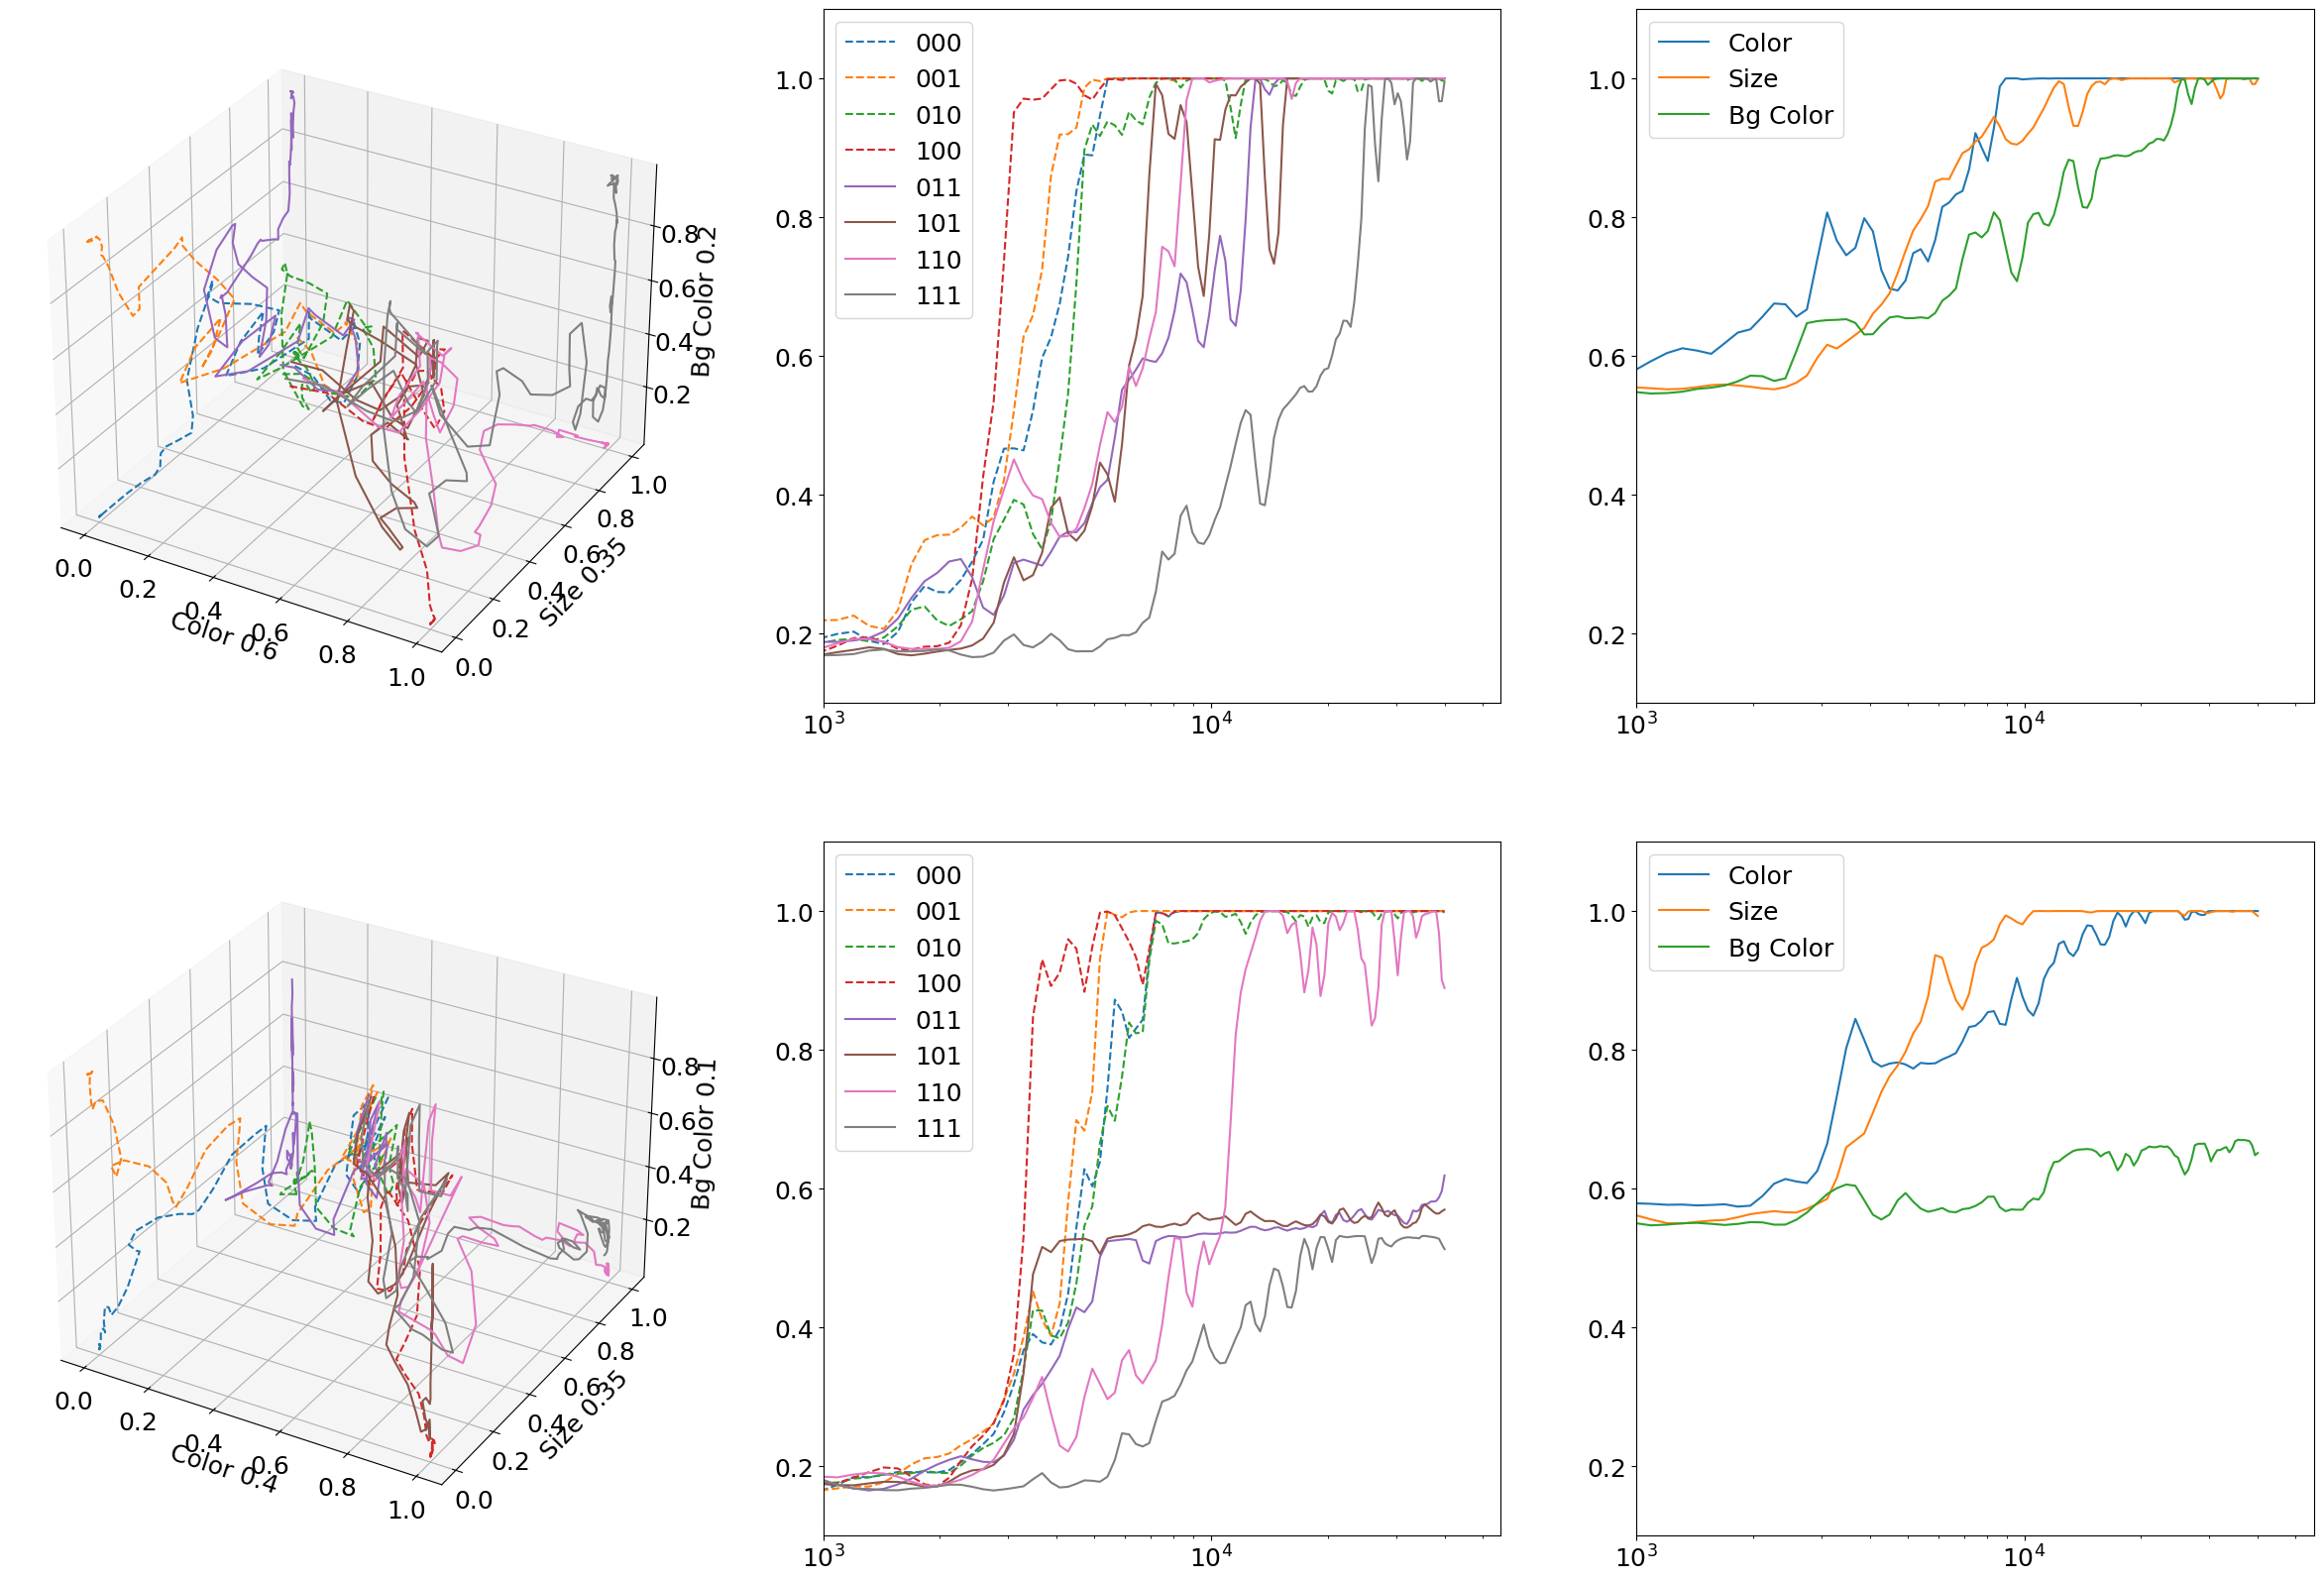

In [117]:
i_datas=[1,4]
fig=plt.figure(figsize=(30,20))
for row,i_data in enumerate(i_datas):
    ax = fig.add_subplot(2,3,3*row+1, projection='3d')
    for i in range(4):
        traj=trajs_trss[i_data,i,:,:]
        plt.plot(traj[:,0],traj[:,1],traj[:,2],ls="--")
    for i in range(4):
        traj=trajs_tess[i_data,i,:,:]
        plt.plot(traj[:,0],traj[:,1],traj[:,2])
    ax.set_xlabel("Color "+str(sep_colss[i_data]))
    ax.set_ylabel("Size "+str(sep_sizess[i_data]))
    ax.set_zlabel("Bg Color "+str(sep_bg_colss[i_data]))

    plt.subplot(2,3,3*row+2)
    for i in range(4):
        ii=[0,1,2,4][i]
        _=plt.plot(save_steps,accs_trss[i_data,i].prod(-1),ls="--",label=labels[ii])
    for i in range(4):
        ii=[3,5,6,7][i]
        _=plt.plot(save_steps,accs_tess[i_data,i].prod(-1),ls="-",label=labels[ii])
    plt.xscale("log")
    plt.ylim(0.1,1.1)
    plt.xlim(left=1000)
    plt.legend()

    plt.subplot(2,3,3*row+3)
    names=["Color","Size","Bg Color"]
    for i in range(3):
        _=plt.plot(save_steps,accs_tess[i_data,:,:,i].mean(0),ls="-",label=names[i])
    plt.xscale("log")
    plt.ylim(0.1,1.1)
    plt.xlim(left=1000)
    plt.legend()
plt.savefig("../figures/final/fig2_proposition.png")


In [118]:
accs_tess.shape

(9, 4, 120, 3)

In [122]:
trajs_trss=[]
trajs_tess=[]
sep_colss=[]
sep_sizess=[]
sep_bg_colss=[]
for key in plot_datass.keys():
    sep_col=key[0]
    sep_size=key[1]
    sep_bg_col=key[2]
    sep_colss.append(float(sep_col))
    sep_sizess.append(float(sep_size))
    sep_bg_colss.append(float(sep_bg_col))
    plot_datas=plot_datass[key]
    classprobs_pred_trs=[]
    classprobs_pred_tes=[]
    for plot_data in plot_datas:
        classprobs_pred_tr=np.array(plot_data['classprobs_pred_tr'])[...,1]
        l_tr=np.array(plot_data['l_tr'])
        classprobs_pred_trs.append(classprobs_pred_tr)
        classprobs_pred_te=np.array(plot_data['classprobs_pred_te'])[...,1]
        classprobs_pred_tes.append(classprobs_pred_te)
        l_te=np.array(plot_data['l_te'])
    classprobs_pred_trs=np.stack(classprobs_pred_trs,axis=0)
    classprobs_pred_tes=np.stack(classprobs_pred_tes,axis=0)

    trajs_trs=[]
    for l in [0,1,2,4]:
        trajs_trs.append(classprobs_pred_trs[:,:,:,l_tr==l].mean((3)))
    trajs_trs=np.stack(trajs_trs,axis=0)
    trajs_tes=[]
    for l in [3,5,6,7]:
        trajs_tes.append(classprobs_pred_tes[:,:,:,l_te==l].mean((3)))
    trajs_tes=np.stack(trajs_tes,axis=0)

    trajs_trs=sim.gaussian_filter1d(trajs_trs,1.0,axis=2,truncate=6.0)
    trajs_tes=sim.gaussian_filter1d(trajs_tes,1.0,axis=2,truncate=6.0)
    trajs_trss.append(trajs_trs)
    trajs_tess.append(trajs_tes)
trajs_trss=np.stack(trajs_trss,axis=0)
trajs_tess=np.stack(trajs_tess,axis=0)
trajs_trss.shape,trajs_tess.shape#run,indice,seed,time,concept

((9, 4, 5, 120, 3), (9, 4, 5, 120, 3))

In [124]:
accs_trss=sigmoid(1/(np.abs(gt_trss[None,:,None,None]-trajs_trss)/thres+1e-9))
accs_tess=sigmoid(1/(np.abs(gt_tess[None,:,None,None]-trajs_tess)/thres+1e-9))

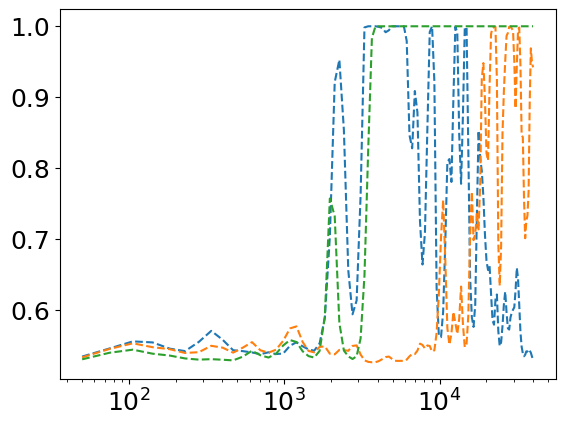

In [153]:
i_data=0
i_class=0
i_seed=0
for i in range(3):
    plt.plot(save_steps,accs_tess[i_data,i_class,i_seed,:,i],ls="--")
plt.xscale("log")

In [134]:
accs_tess.shape

(9, 4, 5, 120, 3)

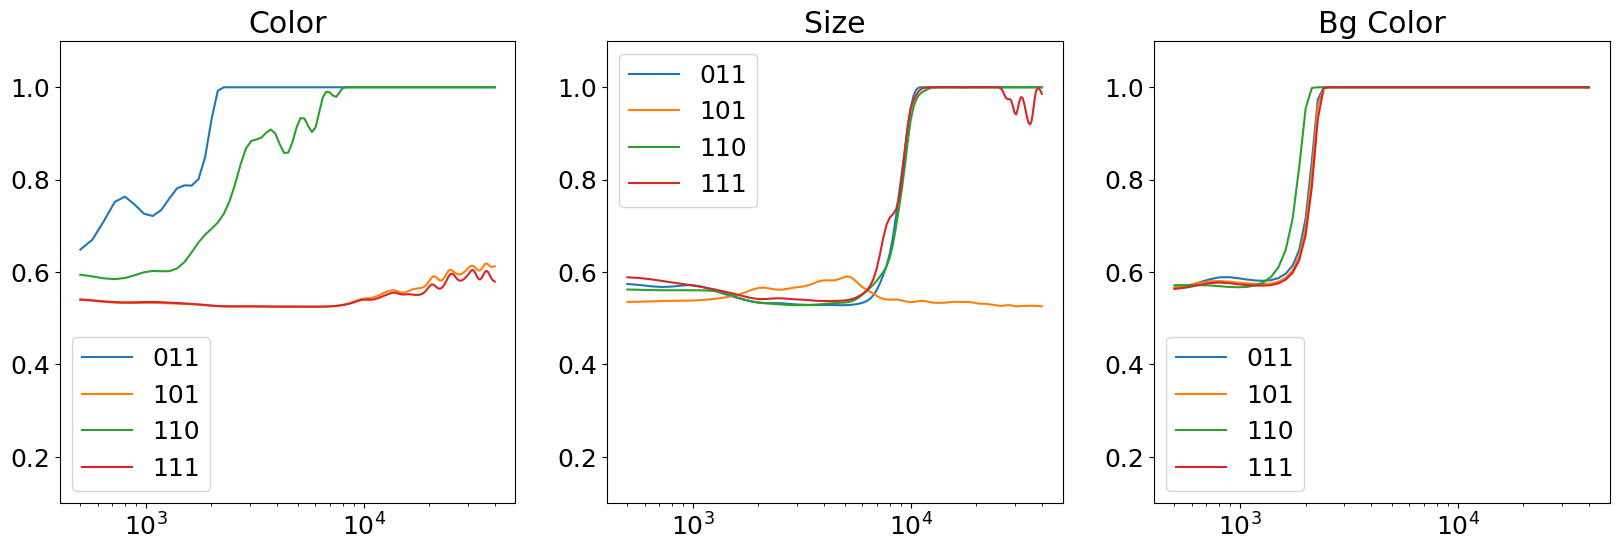

In [259]:
plt.figure(figsize=(20,6))
for j in range(3):
    plt.subplot(1,3,j+1)
    for i in range(4):
        _=plt.plot(save_steps,accs_tess[i_data,i][:,j],ls="-",label=labels_tess[i])
        plt.title(["Color","Size","Bg Color"][j])
    plt.xscale("log")
    plt.legend()
    plt.ylim(0.1,1.1)

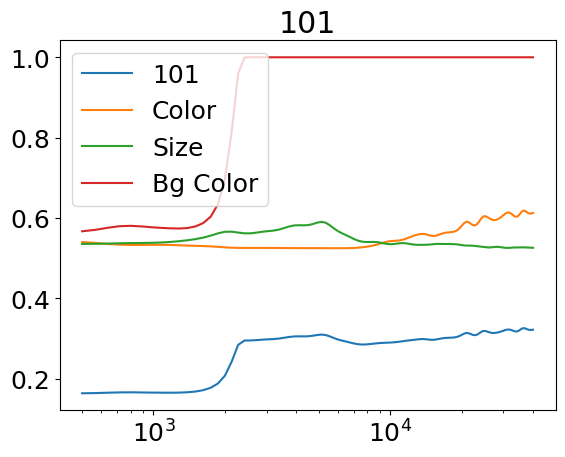

In [260]:
i=1
_=plt.plot(save_steps,accs_tess[i_data,i].prod(-1),ls="-",label=labels_tess[i])
for j in range(3):
    _=plt.plot(save_steps,accs_tess[i_data,i][:,j],ls="-",label=["Color","Size","Bg Color"][j])
plt.title(labels_tess[i])
plt.xscale("log")
plt.legend()

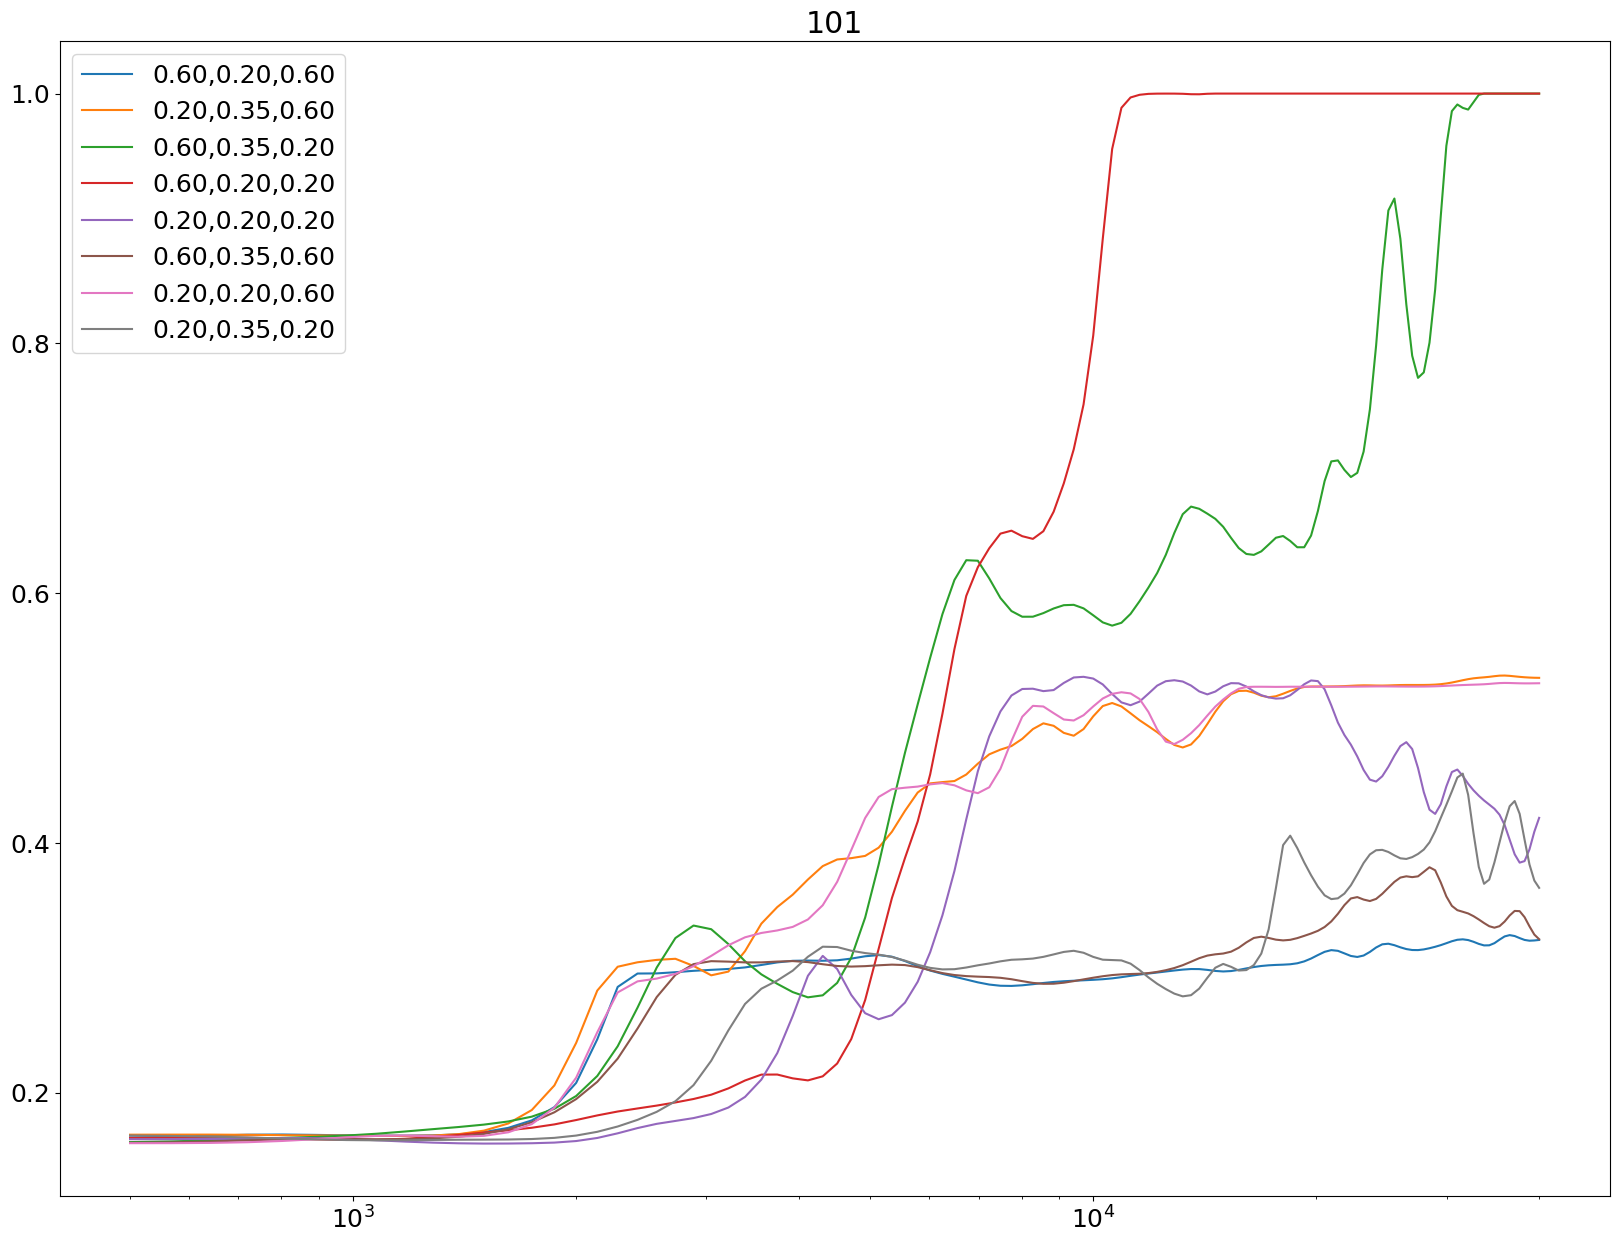

In [261]:
plt.figure(figsize=(20,15))
i_test=1
for i_data in range(8):
    _=plt.plot(save_steps,accs_tess[i_data,i_test].prod(-1),ls="-",label=
                f"{sep_colss[i_data]:.2f},{sep_sizess[i_data]:.2f},{sep_bg_colss[i_data]:.2f}")
plt.title(labels_tess[i_test])
plt.xscale("log")
plt.legend()

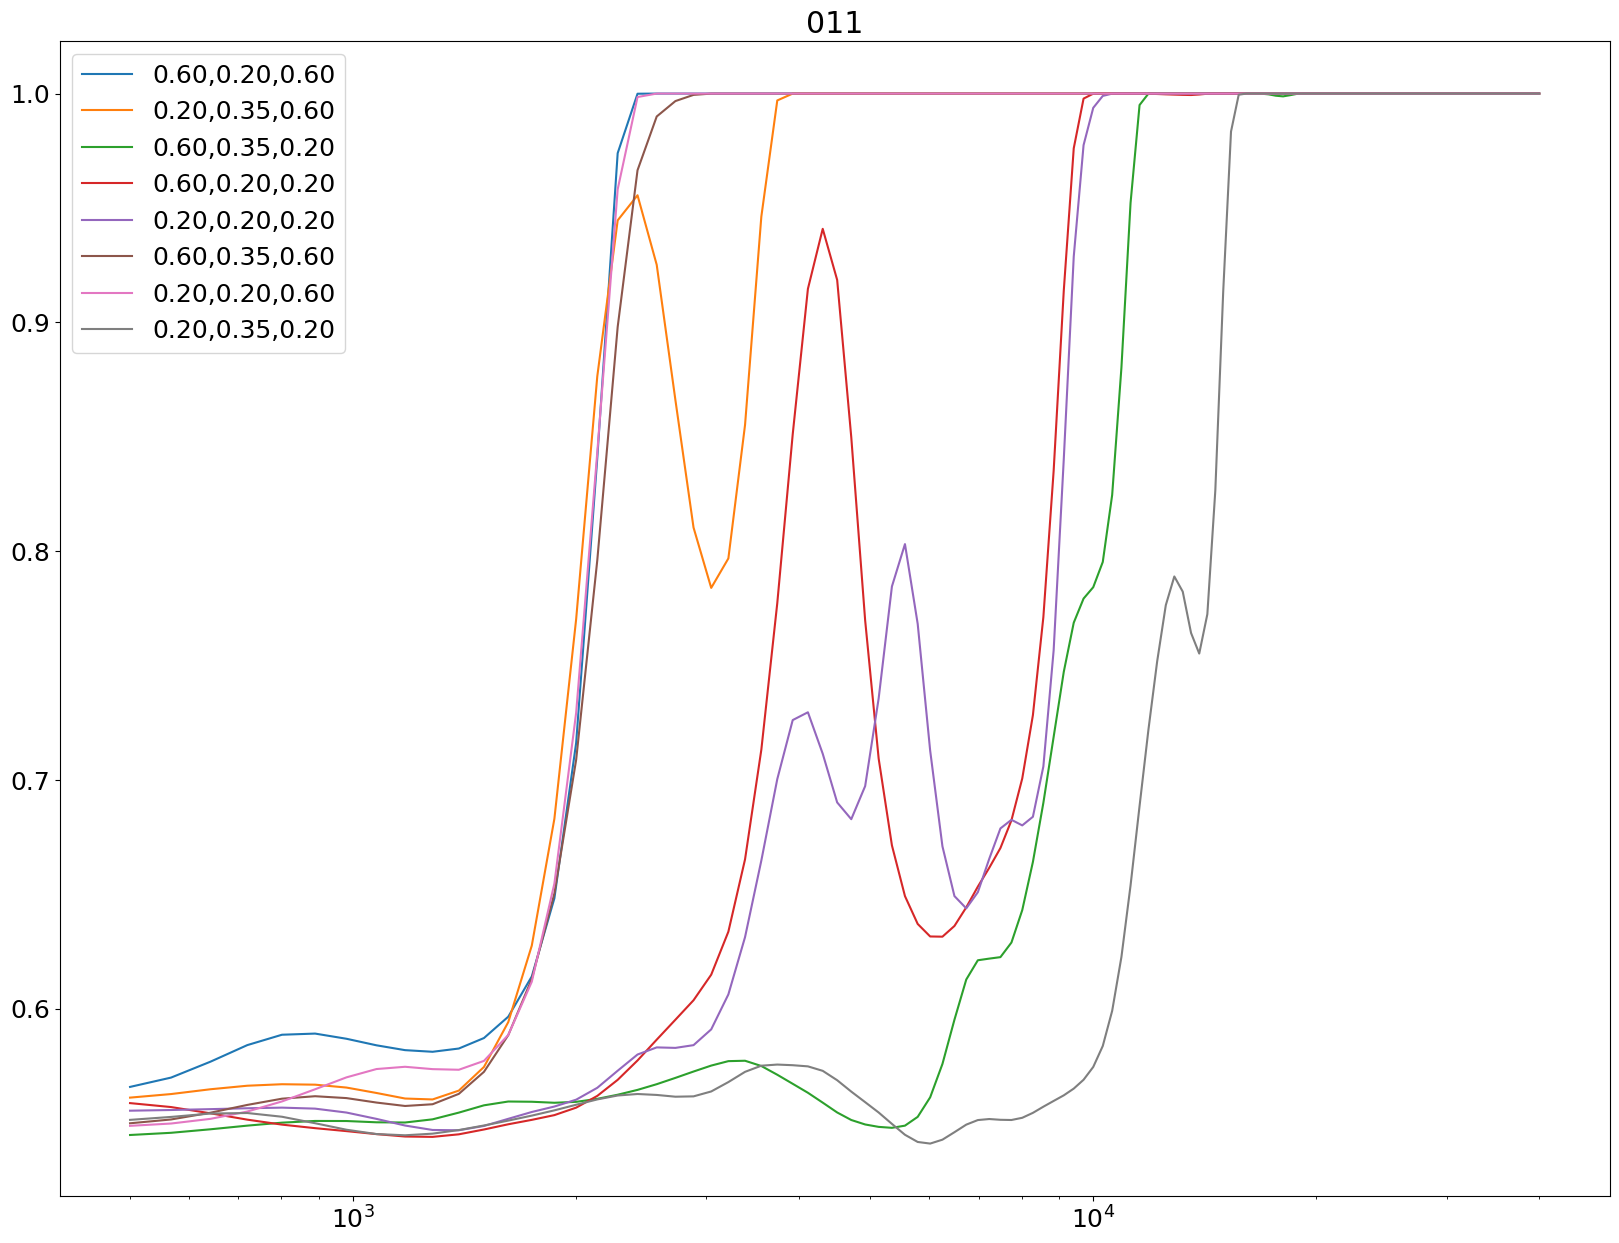

In [240]:
plt.figure(figsize=(20,15))
i_test=0
for i_data in range(8):
    _=plt.plot(save_steps,accs_tess[i_data,i_test][...,2],ls="-",label=
                f"{sep_colss[i_data]:.2f},{sep_sizess[i_data]:.2f},{sep_bg_colss[i_data]:.2f}")
plt.title(labels_tess[i_test])
plt.xscale("log")
plt.legend()

In [229]:
accs_tess[i_data,0].shape

(120, 3)

In [213]:
torch.tensor(9)

tensor(9)